# Model comparison benchmark - result analysis

In [1]:
# Setup
import pandas as pd
import toytree as tt
import numpy as np
import arviz as az
import anndata as ad
import os
import pickle as pkl
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
plot_path = "./plots/"

Functions for getting classification metrics for every result based on ground truth

In [2]:
def get_scores(df):
    """
    Calculates extended binary classification summary statistics, such as TPR, TNR, youden index, f1-score, MCC

    Parameters
    ----------
    df: DataFrame
        Must contain columns tp, tn, fp, fn

    Returns
    -------
    df: DataFrame
        Same df with added columns tpr, tnr, precision, accuracy, youden, f1_score, mcc
    """
    tp = df["tp"].astype("float64")
    tn = df["tn"].astype("float64")
    fp = df["fp"].astype("float64")
    fn = df["fn"].astype("float64")

    tpr = (tp / (tp + fn)).fillna(0)
    df["tpr"] = tpr
    tnr = (tn / (tn + fp)).fillna(0)
    df["tnr"] = tnr
    precision = (tp / (tp + fp)).fillna(0)
    df["precision"] = precision
    fdr = (fp / (tp + fp)).fillna(0)
    df["fdr"] = fdr
    acc = ((tp + tn) / (tp + tn + fp + fn)).fillna(0)
    df["accuracy"] = acc

    df["youden"] = tpr + tnr - 1
    df["f1_score"] = 2 * (tpr * precision / (tpr + precision)).fillna(0)

    df["mcc"] = (((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))).fillna(0)

    return df


def classify(row):
    gt = np.zeros(row["num_otus"])
    if type(row["effect_otus"]) == str:
        eff = eval(row["effect_otus"].replace("[ ", "[").replace("  ", " ").replace(" ", ", "))
    else:
        eff = row["effect_otus"]
    gt[eff] = 1

    pred = np.zeros(row["num_otus"])
    res = [int(x) for x in eval(row["result_otus"])]
    pred[res] = 1

    tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()
    return tp, tn, fp, fn

Read results from locally executed models (everything except scCODA, tascCODA)
Then calculate classification metrics and put them together into one dataframe

In [3]:
dfs = {}
models = ["adaANCOM", "ANCOM", "ANCOMBC", "ALDEx2", "alr_ttest", "alr_wilcoxon"]

results_path = "../../../tascCODA_data/benchmarks/model_comparison/results_other_models/"

for m in models:
    df = pd.read_csv(results_path + f"result_df_{m}.csv", index_col=0)

    classes = df.apply(classify, axis=1)

    df["tp"] = [x[0] for x in classes]
    df["tn"] = [x[1] for x in classes]
    df["fp"] = [x[2] for x in classes]
    df["fn"] = [x[3] for x in classes]
    df = get_scores(df)

    dfs[m] = df

In [4]:
all_dfs = pd.concat(dfs.values())
all_dfs


model result_nodes                     result_otus  dataset_id  \
0         adaANCOM           []                              []           0   
1         adaANCOM       ['12']                      ['9', '7']           1   
2         adaANCOM           []                              []           2   
3         adaANCOM           []                              []           3   
4         adaANCOM           []                              []           4   
...            ...          ...                             ...         ...   
1275  alr_wilcoxon           []                [56, 57, 58, 72]        1275   
1276  alr_wilcoxon           []            [28, 55, 56, 57, 72]        1276   
1277  alr_wilcoxon           []            [28, 55, 56, 58, 72]        1277   
1278  alr_wilcoxon           []                              []        1278   
1279  alr_wilcoxon           []  [0, 9, 28, 55, 56, 57, 58, 72]        1279   

       effect_nodes          effect_otus  num_samples  effect_size  num_otus  \
0        [12  4  0]            [8 0 4 7]            5          0.3        10   
1        [12  4  0]            [8 0 4 7]            5          0.3        10   
2        [12  4  0]            [8 0 4 7]            5          0.3        10   
3        [12  4  0]            [8 0 4 7]            5          0.3        10   
4        [12  4  0]            [8 0 4 7]            5          0.3        10   
...             ...                  ...          ...          ...       ...   
1275  [113  72  28]  [72 55 56 57 58 28]           50          0.9       100   
1276  [113  72  28]  [72 55 56 57 58 28]           50          0.9       100   
1277  [113  72  28]  [72 55 56 57 58 28]           50          0.9       100   
1278  [113  72  28]  [72 55 56 57 58 28]           50          0.9       100   
1279  [113  72  28]  [72 55 56 57 58 28]           50          0.9       100   

      tp  ...  fp  fn       tpr       tnr  precision   fdr  accuracy  \
0      0  ...   0   4  0.000000  1.000000       0.00  0.00      0.60   
1      1  ...   1   3  0.250000  0.833333       0.50  0.50      0.60   
2      0  ...   0   4  0.000000  1.000000       0.00  0.00      0.60   
3      0  ...   0   4  0.000000  1.000000       0.00  0.00      0.60   
4      0  ...   0   4  0.000000  1.000000       0.00  0.00      0.60   
...   ..  ...  ..  ..       ...       ...        ...   ...       ...   
1275   4  ...   0   2  0.666667  1.000000       1.00  0.00      0.98   
1276   5  ...   0   1  0.833333  1.000000       1.00  0.00      0.99   
1277   5  ...   0   1  0.833333  1.000000       1.00  0.00      0.99   
1278   0  ...   0   6  0.000000  1.000000       0.00  0.00      0.94   
1279   6  ...   2   0  1.000000  0.978723       0.75  0.25      0.98   

        youden  f1_score       mcc  
0     0.000000  0.000000  0.000000  
1     0.083333  0.333333  0.102062  
2     0.000000  0.000000  0.000000  
3     0.000000  0.000000  0.000000  
4     0.000000  0.000000  0.000000  
...        ...       ...       ...  
1275  0.666667  0.800000  0.807947  
1276  0.833333  0.909091  0.908054  
1277  0.833333  0.909091  0.908054  
1278  0.000000  0.000000  0.000000  
1279  0.978723  0.857143  0.856763  

[7680 rows x 21 columns]

## Add tree_agg and scCODA

In the same way, read the results from tascCODA and scCODA, calculate classification metrics and combine them

In [5]:
tree_agg_path = results_path = "../../../tascCODA_data/benchmarks/model_comparison/results_tasccoda_sccoda/"

tree_agg_res = []

for f in os.listdir(tree_agg_path):
    if f.startswith("result_df"):
        tree_agg_res.append(pd.read_csv(tree_agg_path + f, index_col=0))

tree_agg_df = pd.concat(tree_agg_res)
tree_agg_df

model reg_method  lambda   phi result_nodes       result_otus  \
0   tree_agg      new_3     NaN   1.0           []                []   
1   tree_agg      new_3     NaN   1.0           []                []   
2   tree_agg      new_3     NaN   1.0       ['61']  [44, 45, 46, 47]   
3   tree_agg      new_3     NaN   1.0           []                []   
4   tree_agg      new_3     NaN   1.0           []                []   
..       ...        ...     ...   ...          ...               ...   
45  tree_agg      new_3     NaN  10.0       ['45']              [45]   
46  tree_agg      new_3     NaN  10.0       ['40']              [40]   
47  tree_agg      new_3     NaN  10.0           []                []   
48  tree_agg      new_3     NaN  10.0        ['5']               [5]   
49  tree_agg      new_3     NaN  10.0           []                []   

    mean_log_prob  acc_rate  num_samples  effect_size  num_otus  dataset_id  
0    -5633.074308   0.84925           10          0.5        50         750  
1    -5906.966826   0.85165           10          0.5        50         751  
2    -5935.814658   0.86305           10          0.5        50         752  
3    -6027.415502   0.84095           10          0.5        50         753  
4    -5912.660682   0.84740           10          0.5        50         754  
..            ...       ...          ...          ...       ...         ...  
45   -5926.021540   0.85775           10          0.5        50         745  
46   -5834.394197   0.85165           10          0.5        50         746  
47   -5697.796030   0.84470           10          0.5        50         747  
48   -5917.720165   0.84350           10          0.5        50         748  
49   -5874.866712   0.84970           10          0.5        50         749  

[10240 rows x 12 columns]

In [6]:
ground_truth = {
    10: ([0, 4, 12], [0, 4, 7, 8]),
    30: ([33, 7, 0], [0, 7, 13, 14, 15, 16]),
    50: ([61, 40, 5], [5, 40, 44, 45, 46, 47]),
    100: ([113, 72, 28], [72, 55, 56, 57, 58, 28])
}

tree_agg_df["effect_nodes"] = [ground_truth[x][0] for x in tree_agg_df["num_otus"]]
tree_agg_df["effect_otus"] = [ground_truth[x][1] for x in tree_agg_df["num_otus"]]
tree_agg_df

model reg_method  lambda   phi result_nodes       result_otus  \
0   tree_agg      new_3     NaN   1.0           []                []   
1   tree_agg      new_3     NaN   1.0           []                []   
2   tree_agg      new_3     NaN   1.0       ['61']  [44, 45, 46, 47]   
3   tree_agg      new_3     NaN   1.0           []                []   
4   tree_agg      new_3     NaN   1.0           []                []   
..       ...        ...     ...   ...          ...               ...   
45  tree_agg      new_3     NaN  10.0       ['45']              [45]   
46  tree_agg      new_3     NaN  10.0       ['40']              [40]   
47  tree_agg      new_3     NaN  10.0           []                []   
48  tree_agg      new_3     NaN  10.0        ['5']               [5]   
49  tree_agg      new_3     NaN  10.0           []                []   

    mean_log_prob  acc_rate  num_samples  effect_size  num_otus  dataset_id  \
0    -5633.074308   0.84925           10          0.5        50         750   
1    -5906.966826   0.85165           10          0.5        50         751   
2    -5935.814658   0.86305           10          0.5        50         752   
3    -6027.415502   0.84095           10          0.5        50         753   
4    -5912.660682   0.84740           10          0.5        50         754   
..            ...       ...          ...          ...       ...         ...   
45   -5926.021540   0.85775           10          0.5        50         745   
46   -5834.394197   0.85165           10          0.5        50         746   
47   -5697.796030   0.84470           10          0.5        50         747   
48   -5917.720165   0.84350           10          0.5        50         748   
49   -5874.866712   0.84970           10          0.5        50         749   

   effect_nodes              effect_otus  
0   [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
1   [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
2   [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
3   [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
4   [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
..          ...                      ...  
45  [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
46  [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
47  [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
48  [61, 40, 5]  [5, 40, 44, 45, 46, 47]  
49  [61, 40, 5]  [5, 40, 44, 45, 46, 47]  

[10240 rows x 14 columns]

In [7]:
classes = tree_agg_df.apply(classify, axis=1)

tree_agg_df["tp"] = [x[0] for x in classes]
tree_agg_df["tn"] = [x[1] for x in classes]
tree_agg_df["fp"] = [x[2] for x in classes]
tree_agg_df["fn"] = [x[3] for x in classes]
tree_agg_df = get_scores(tree_agg_df)
tree_agg_df


model reg_method  lambda   phi result_nodes       result_otus  \
0   tree_agg      new_3     NaN   1.0           []                []   
1   tree_agg      new_3     NaN   1.0           []                []   
2   tree_agg      new_3     NaN   1.0       ['61']  [44, 45, 46, 47]   
3   tree_agg      new_3     NaN   1.0           []                []   
4   tree_agg      new_3     NaN   1.0           []                []   
..       ...        ...     ...   ...          ...               ...   
45  tree_agg      new_3     NaN  10.0       ['45']              [45]   
46  tree_agg      new_3     NaN  10.0       ['40']              [40]   
47  tree_agg      new_3     NaN  10.0           []                []   
48  tree_agg      new_3     NaN  10.0        ['5']               [5]   
49  tree_agg      new_3     NaN  10.0           []                []   

    mean_log_prob  acc_rate  num_samples  effect_size  ...  fp  fn       tpr  \
0    -5633.074308   0.84925           10          0.5  ...   0   6  0.000000   
1    -5906.966826   0.85165           10          0.5  ...   0   6  0.000000   
2    -5935.814658   0.86305           10          0.5  ...   0   2  0.666667   
3    -6027.415502   0.84095           10          0.5  ...   0   6  0.000000   
4    -5912.660682   0.84740           10          0.5  ...   0   6  0.000000   
..            ...       ...          ...          ...  ...  ..  ..       ...   
45   -5926.021540   0.85775           10          0.5  ...   0   5  0.166667   
46   -5834.394197   0.85165           10          0.5  ...   0   5  0.166667   
47   -5697.796030   0.84470           10          0.5  ...   0   6  0.000000   
48   -5917.720165   0.84350           10          0.5  ...   0   5  0.166667   
49   -5874.866712   0.84970           10          0.5  ...   0   6  0.000000   

    tnr  precision  fdr  accuracy    youden  f1_score       mcc  
0   1.0        0.0  0.0      0.88  0.000000  0.000000  0.000000  
1   1.0        0.0  0.0      0.88  0.000000  0.000000  0.000000  
2   1.0        1.0  0.0      0.96  0.666667  0.800000  0.798549  
3   1.0        0.0  0.0      0.88  0.000000  0.000000  0.000000  
4   1.0        0.0  0.0      0.88  0.000000  0.000000  0.000000  
..  ...        ...  ...       ...       ...       ...       ...  
45  1.0        1.0  0.0      0.90  0.166667  0.285714  0.386859  
46  1.0        1.0  0.0      0.90  0.166667  0.285714  0.386859  
47  1.0        0.0  0.0      0.88  0.000000  0.000000  0.000000  
48  1.0        1.0  0.0      0.90  0.166667  0.285714  0.386859  
49  1.0        0.0  0.0      0.88  0.000000  0.000000  0.000000  

[10240 rows x 26 columns]

## Merged results

Combine all models and make nice plots

In [8]:
def get_num_eff(row):
    if row["model"] in ["tree_agg", "adaANCOM"]:
        return len([int(x) for x in eval(row["result_nodes"])])
    else:
        return len([int(x) for x in eval(row["result_otus"])])

# Calculate number of efects and hamming distance
res_full = pd.concat([all_dfs, tree_agg_df]).fillna(0)

num_eff =  classes = res_full.apply(get_num_eff, axis=1)
res_full["num_effects"] = num_eff + 0.001
res_full["hamming"] = res_full["fn"] + res_full["fp"]
res_full

model result_nodes result_otus  dataset_id effect_nodes  \
0   adaANCOM           []          []           0   [12  4  0]   
1   adaANCOM       ['12']  ['9', '7']           1   [12  4  0]   
2   adaANCOM           []          []           2   [12  4  0]   
3   adaANCOM           []          []           3   [12  4  0]   
4   adaANCOM           []          []           4   [12  4  0]   
..       ...          ...         ...         ...          ...   
45  tree_agg       ['45']        [45]         745  [61, 40, 5]   
46  tree_agg       ['40']        [40]         746  [61, 40, 5]   
47  tree_agg           []          []         747  [61, 40, 5]   
48  tree_agg        ['5']         [5]         748  [61, 40, 5]   
49  tree_agg           []          []         749  [61, 40, 5]   

                effect_otus  num_samples  effect_size  num_otus  tp  ...  \
0                 [8 0 4 7]            5          0.3        10   0  ...   
1                 [8 0 4 7]            5          0.3        10   1  ...   
2                 [8 0 4 7]            5          0.3        10   0  ...   
3                 [8 0 4 7]            5          0.3        10   0  ...   
4                 [8 0 4 7]            5          0.3        10   0  ...   
..                      ...          ...          ...       ...  ..  ...   
45  [5, 40, 44, 45, 46, 47]           10          0.5        50   1  ...   
46  [5, 40, 44, 45, 46, 47]           10          0.5        50   1  ...   
47  [5, 40, 44, 45, 46, 47]           10          0.5        50   0  ...   
48  [5, 40, 44, 45, 46, 47]           10          0.5        50   1  ...   
49  [5, 40, 44, 45, 46, 47]           10          0.5        50   0  ...   

      youden  f1_score       mcc  reg_method  lambda   phi  mean_log_prob  \
0   0.000000  0.000000  0.000000           0     0.0   0.0       0.000000   
1   0.083333  0.333333  0.102062           0     0.0   0.0       0.000000   
2   0.000000  0.000000  0.000000           0     0.0   0.0       0.000000   
3   0.000000  0.000000  0.000000           0     0.0   0.0       0.000000   
4   0.000000  0.000000  0.000000           0     0.0   0.0       0.000000   
..       ...       ...       ...         ...     ...   ...            ...   
45  0.166667  0.285714  0.386859       new_3     0.0  10.0   -5926.021540   
46  0.166667  0.285714  0.386859       new_3     0.0  10.0   -5834.394197   
47  0.000000  0.000000  0.000000       new_3     0.0  10.0   -5697.796030   
48  0.166667  0.285714  0.386859       new_3     0.0  10.0   -5917.720165   
49  0.000000  0.000000  0.000000       new_3     0.0  10.0   -5874.866712   

    acc_rate  num_effects  hamming  
0    0.00000        0.001        4  
1    0.00000        1.001        4  
2    0.00000        0.001        4  
3    0.00000        0.001        4  
4    0.00000        0.001        4  
..       ...          ...      ...  
45   0.85775        1.001        5  
46   0.85165        1.001        5  
47   0.84470        0.001        6  
48   0.84350        1.001        5  
49   0.84970        0.001        6  

[17920 rows x 28 columns]

In [21]:
# Tick patterns for values of phi
ticks = [(1,1,1,4), (1,1), (1,1,1,1,1,4), "", (4,1,1,1), (4,1), (4,1,1,1,1,1)]

# color and tick assignments
colors = {
    "adaANCOM": 2,
    "ANCOM": 3,
    "ANCOMBC": 4,
    "sccoda": 1,
    "alr_ttest": 6,
    "alr_wilcoxon": 7,
    "ALDEx2": 5,
    "tree_agg": 0,
}

linestyles = {
    "adaANCOM": 0,
    "ANCOM": 0,
    "ANCOMBC": 1,
    "sccoda": 1,
    "alr_ttest": 0,
    "alr_wilcoxon": 1,
    "ALDEx2": 2,
    "tree_agg": 0,
}
linestyles_phi = {
    0: 3,
    -10: 0,
    -5: 1,
    -1: 2,
    1: 4,
    5: 5,
    10: 6
}
res_full["color"] = [colors[m] for m in res_full["model"]]
res_full["style"] = [linestyles[m] for m in res_full["model"]]
res_full["style_phi"] = [linestyles_phi[p] for p in res_full["phi"]]
res_full["Replicates per group"] = res_full["num_samples"]
res_full["p"] = res_full["num_otus"]
res_full

# legend labels
leg_labels_=["Model", "tascCODA", "scCODA", "adaANCOM", "ANCOM", "ANCOM-BC", "ALDEx2", "ALR + t-test", "ALR + Wilcoxon",
             r"$\phi$", "-10", "-5", "-1", "0", "1", "5", "10"]

plot_path = "./plots/"

Plots:

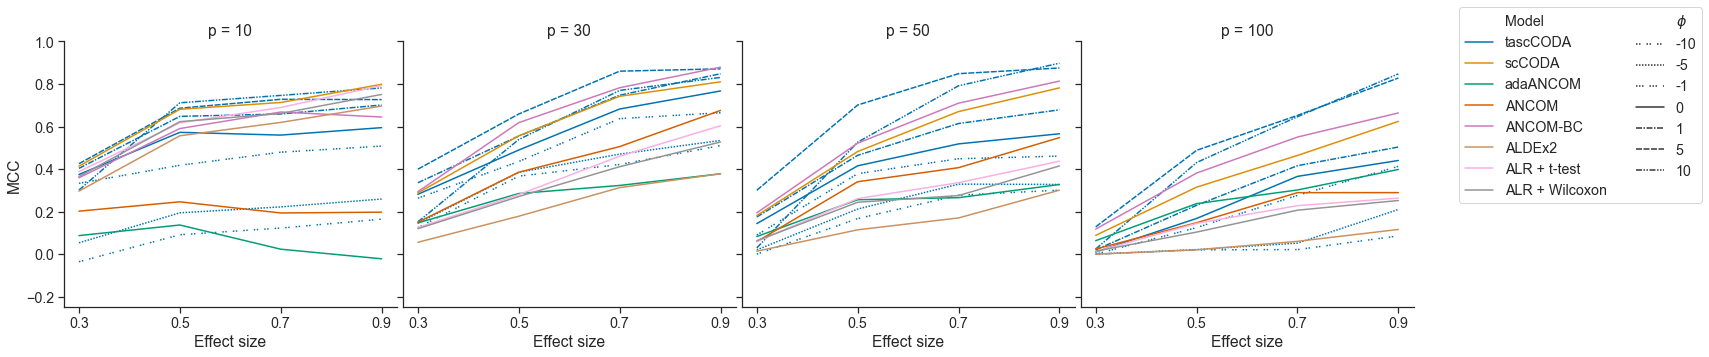

In [23]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_full, x="effect_size", y="mcc",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                # row="num_otus",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(ylim=[-0.25,1], xticks=[0.3, 0.5, 0.7, 0.9])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "MCC").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_mcc_4facets_v2.svg", bbox_inches="tight", format="svg")
plt.show()


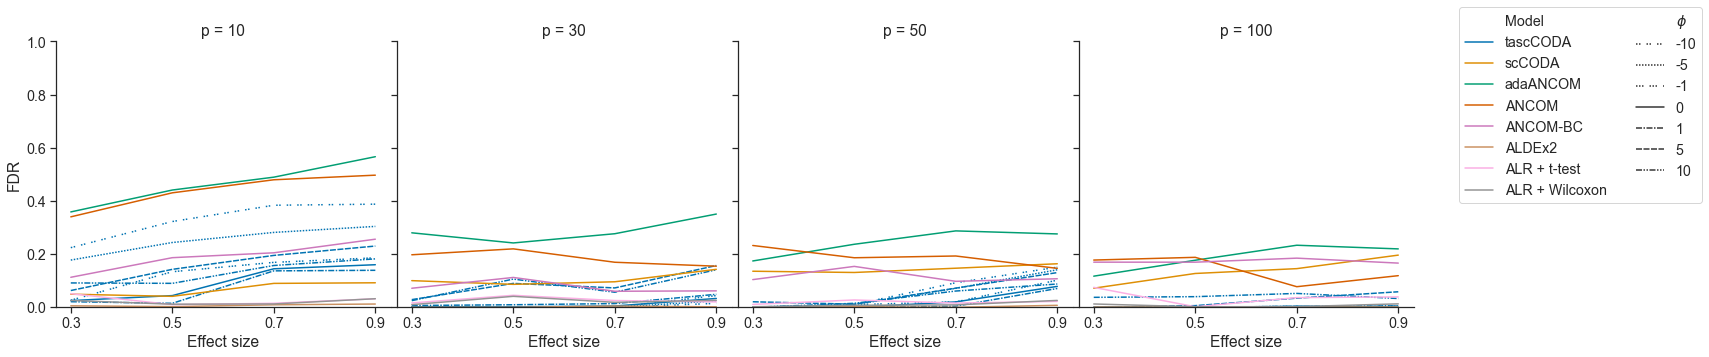

In [24]:
g = sns.relplot(data=res_full, x="effect_size", y="fdr",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                # row="num_otus",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(ylim=[0,1], xticks=[0.3, 0.5, 0.7, 0.9])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "FDR").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_fdr_4facets_v2.svg", bbox_inches="tight", format="svg")
plt.show()

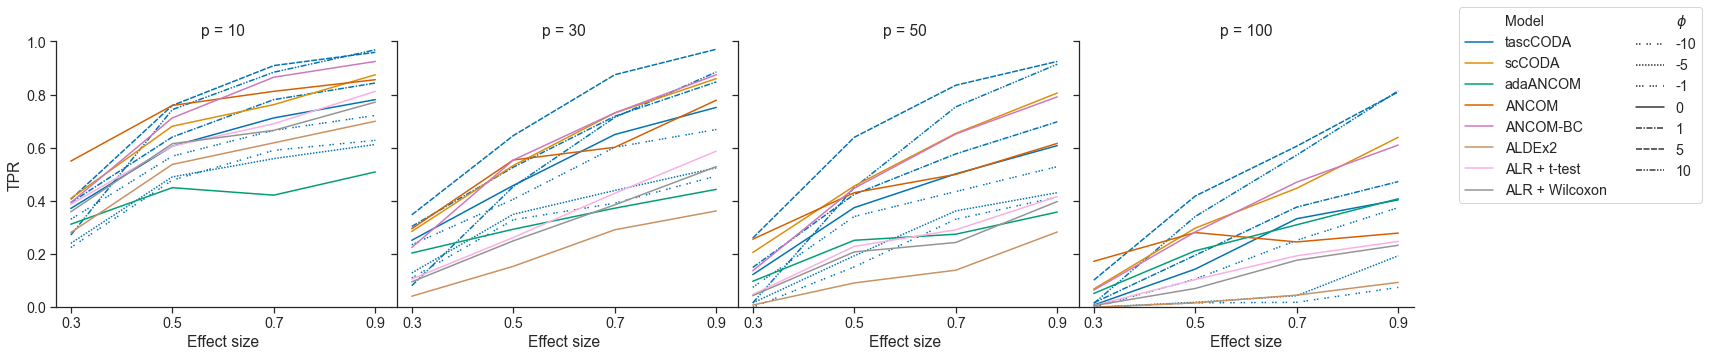

In [25]:
g = sns.relplot(data=res_full, x="effect_size", y="tpr",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                # row="num_otus",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(ylim=[0,1], xticks=[0.3, 0.5, 0.7, 0.9])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

(g.set_axis_labels("Effect size", "TPR").tight_layout(w_pad=0))

plt.savefig(plot_path + "model_comp_tpr_4facets_v2.svg", bbox_inches="tight", format="svg")
plt.show()

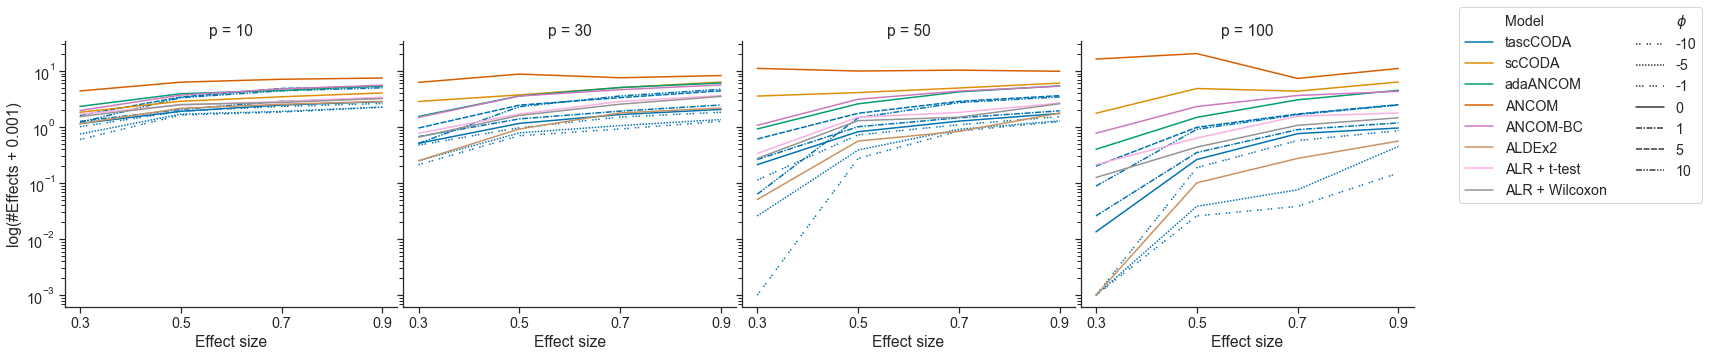

In [26]:
g = sns.relplot(data=res_full, x="effect_size", y="num_effects",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                # row="num_otus",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(yscale="log", xticks=[0.3, 0.5, 0.7, 0.9])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "log(#Effects + 0.001)").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_effects_4facets_v2.svg", bbox_inches="tight", format="svg")
plt.show()

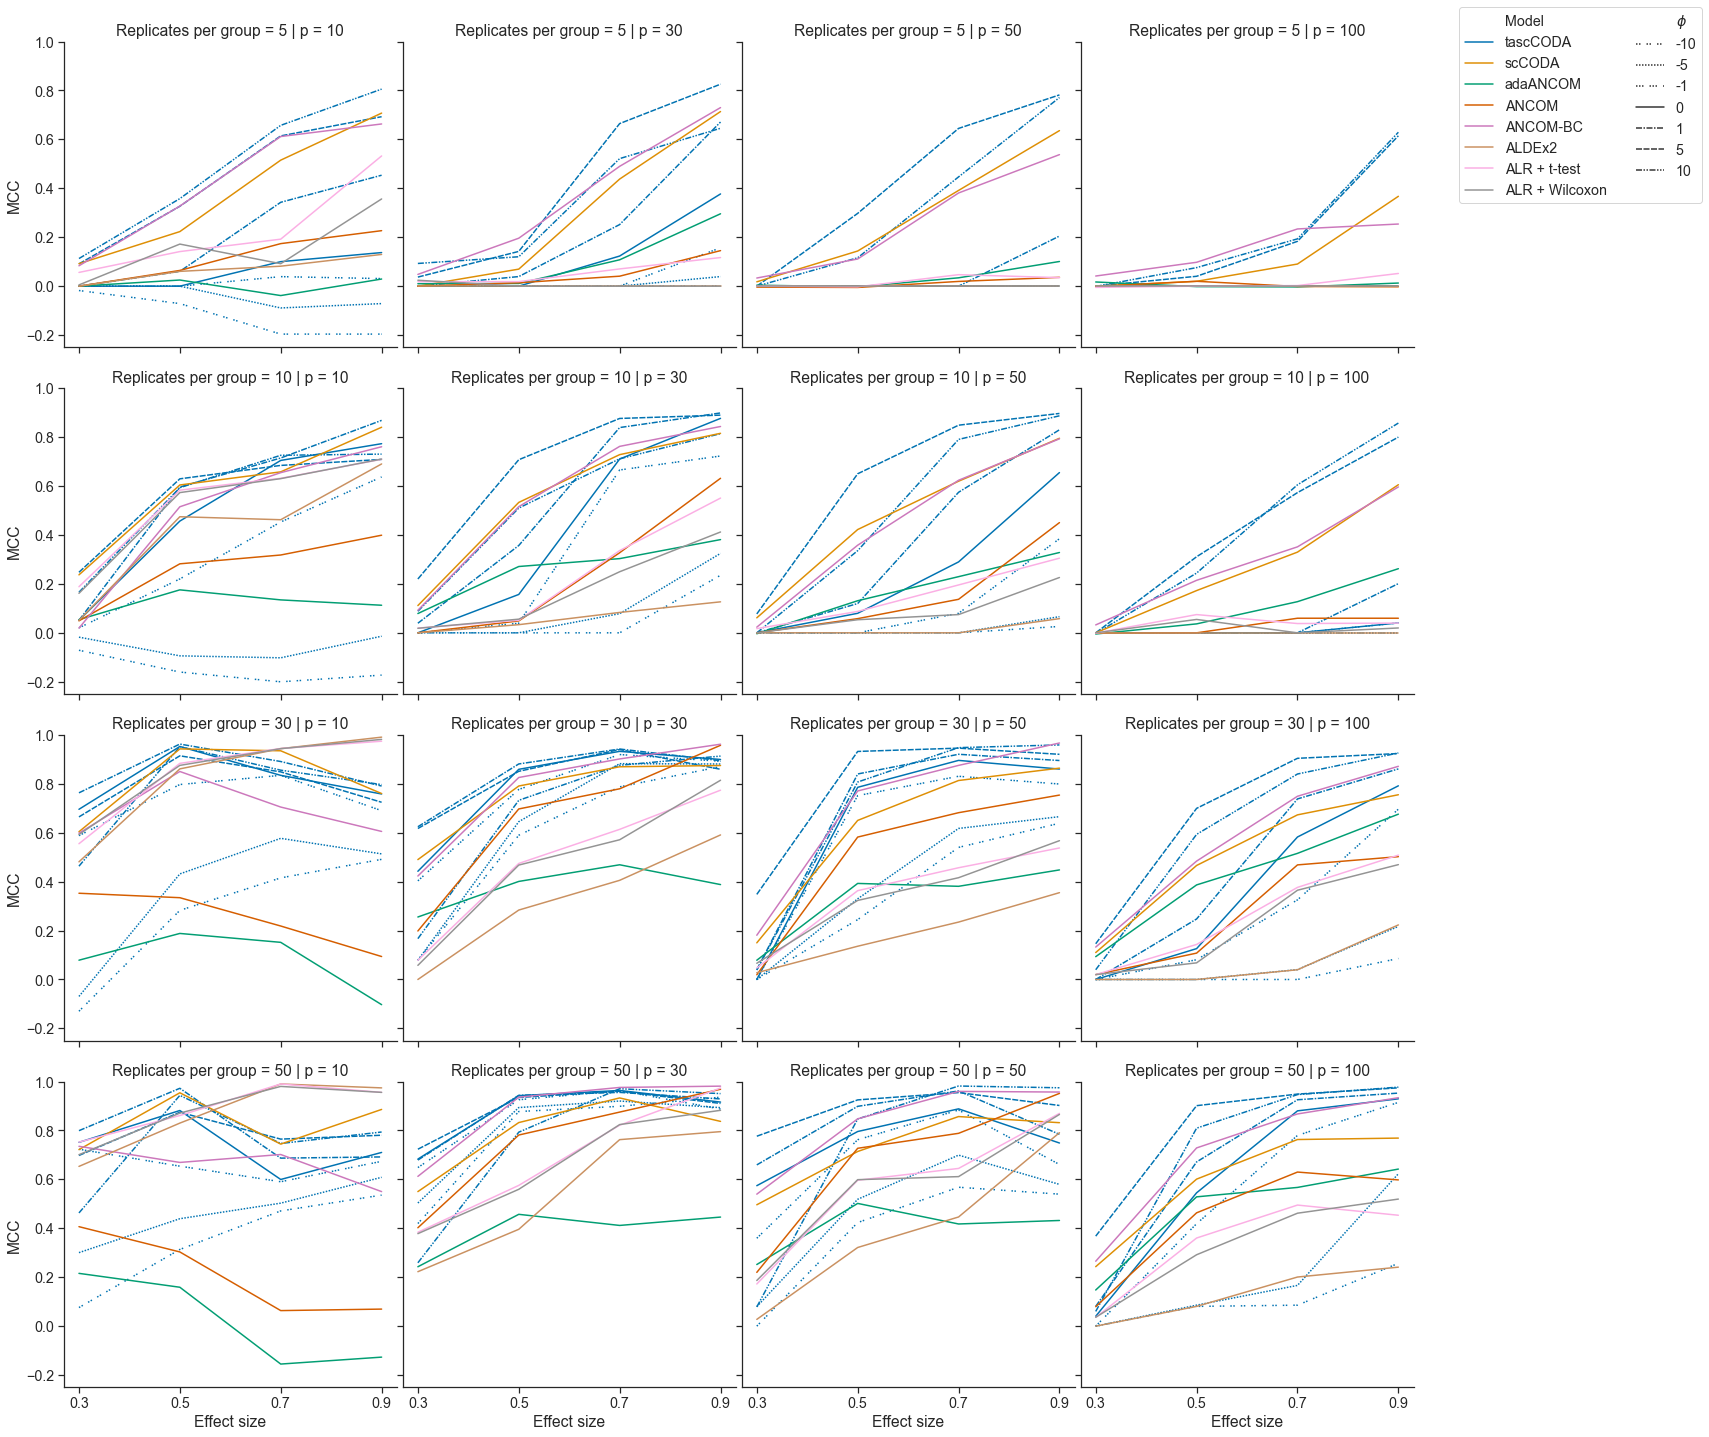

In [27]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_full, x="effect_size", y="mcc",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                row="Replicates per group",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(ylim=[-0.25,1], xticks=[0.3, 0.5, 0.7, 0.9])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "MCC").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_mcc_16facets_v2.svg", bbox_inches="tight", format="svg")
plt.show()


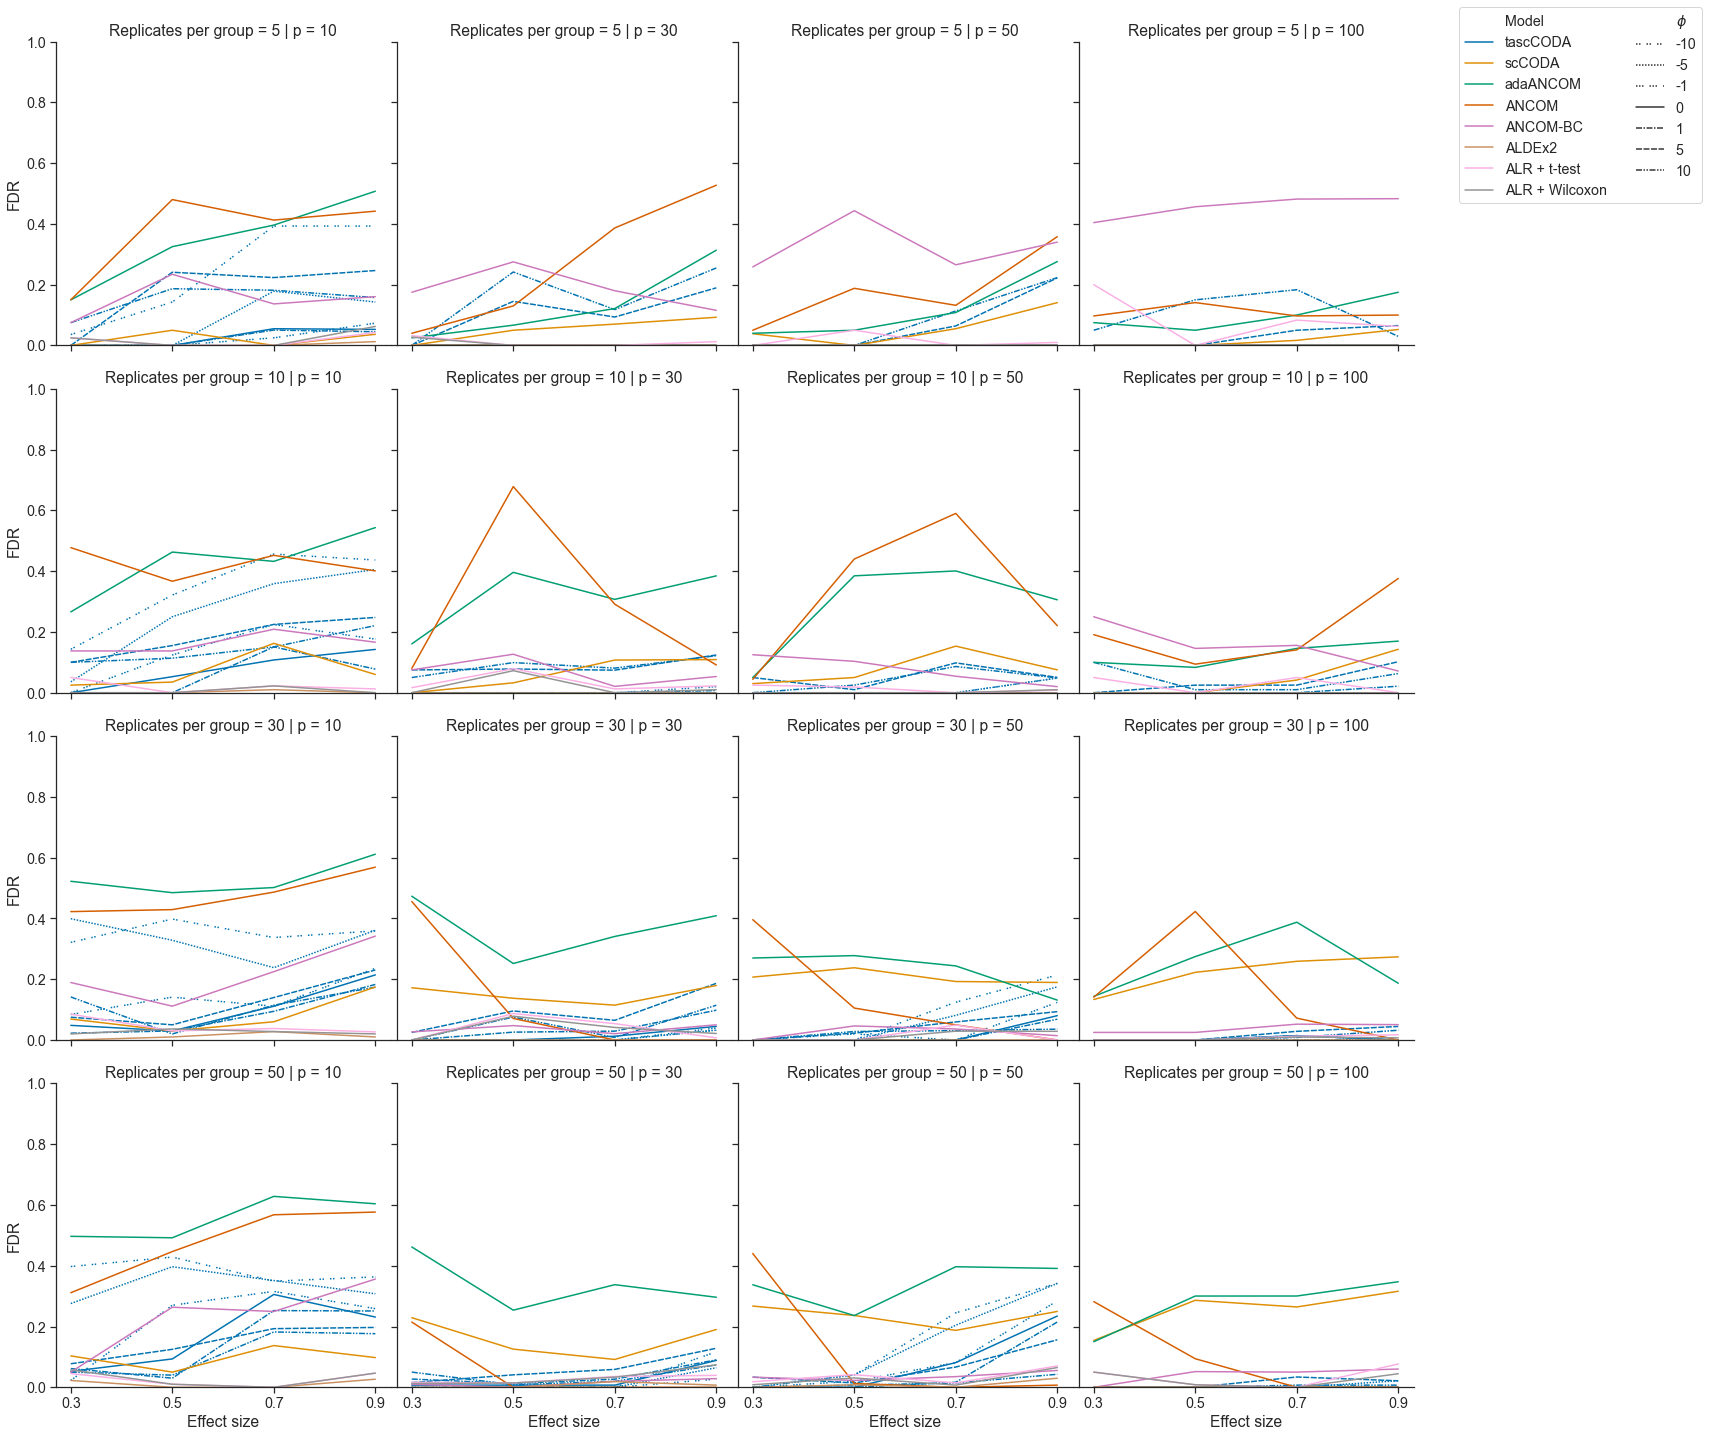

In [28]:
g = sns.relplot(data=res_full, x="effect_size", y="fdr",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                row="Replicates per group",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(ylim=[0,1], xticks=[0.3, 0.5, 0.7, 0.9])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "FDR").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_fdr_16facets_v2.svg", bbox_inches="tight", format="svg")
plt.show()

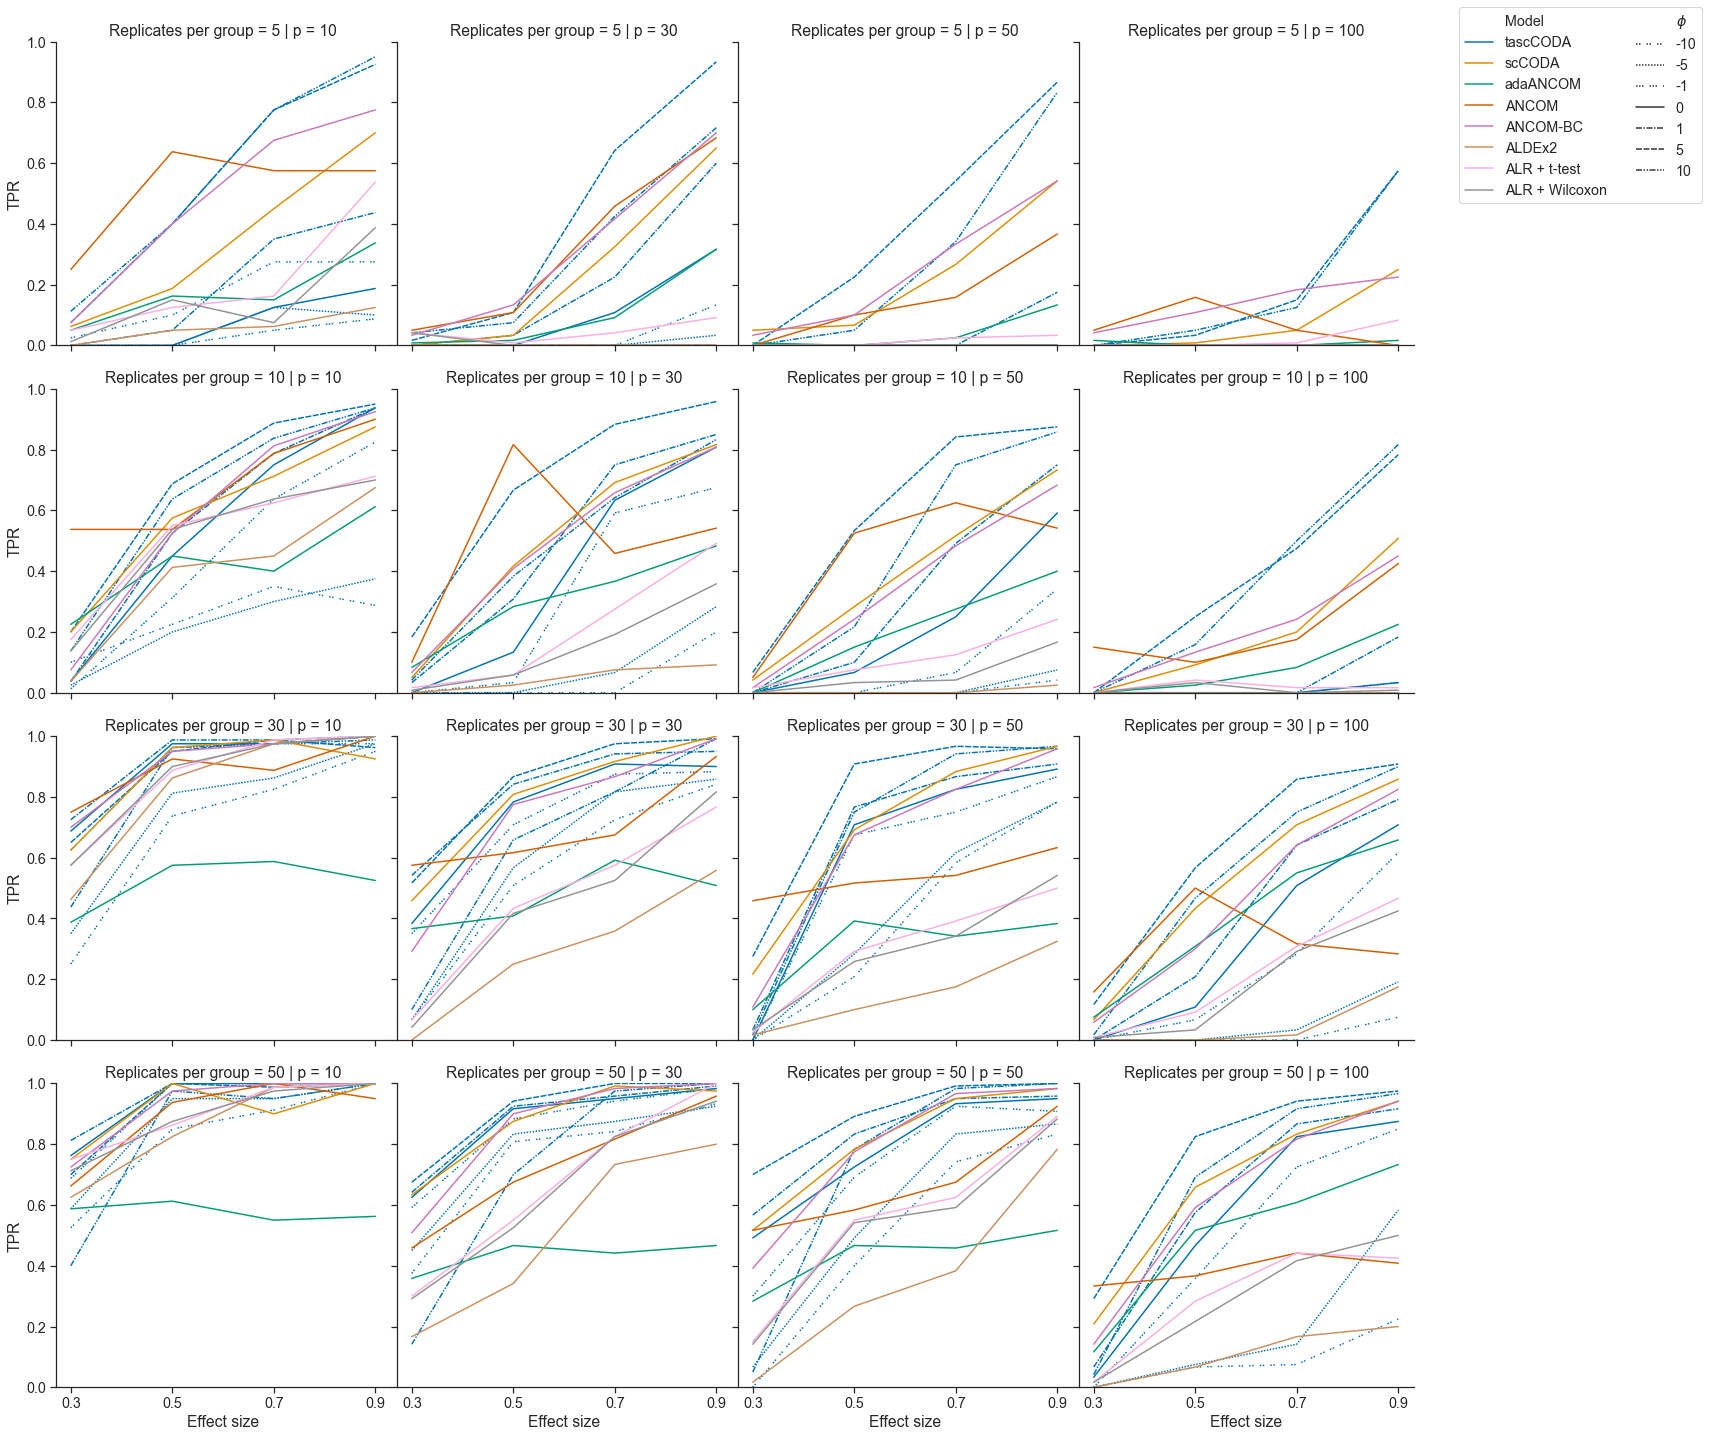

In [29]:
g = sns.relplot(data=res_full, x="effect_size", y="tpr",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                row="Replicates per group",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(ylim=[0,1], xticks=[0.3, 0.5, 0.7, 0.9])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

(g.set_axis_labels("Effect size", "TPR").tight_layout(w_pad=0))

plt.savefig(plot_path + "model_comp_tpr_16facets_v2.svg", bbox_inches="tight", format="svg")
plt.show()

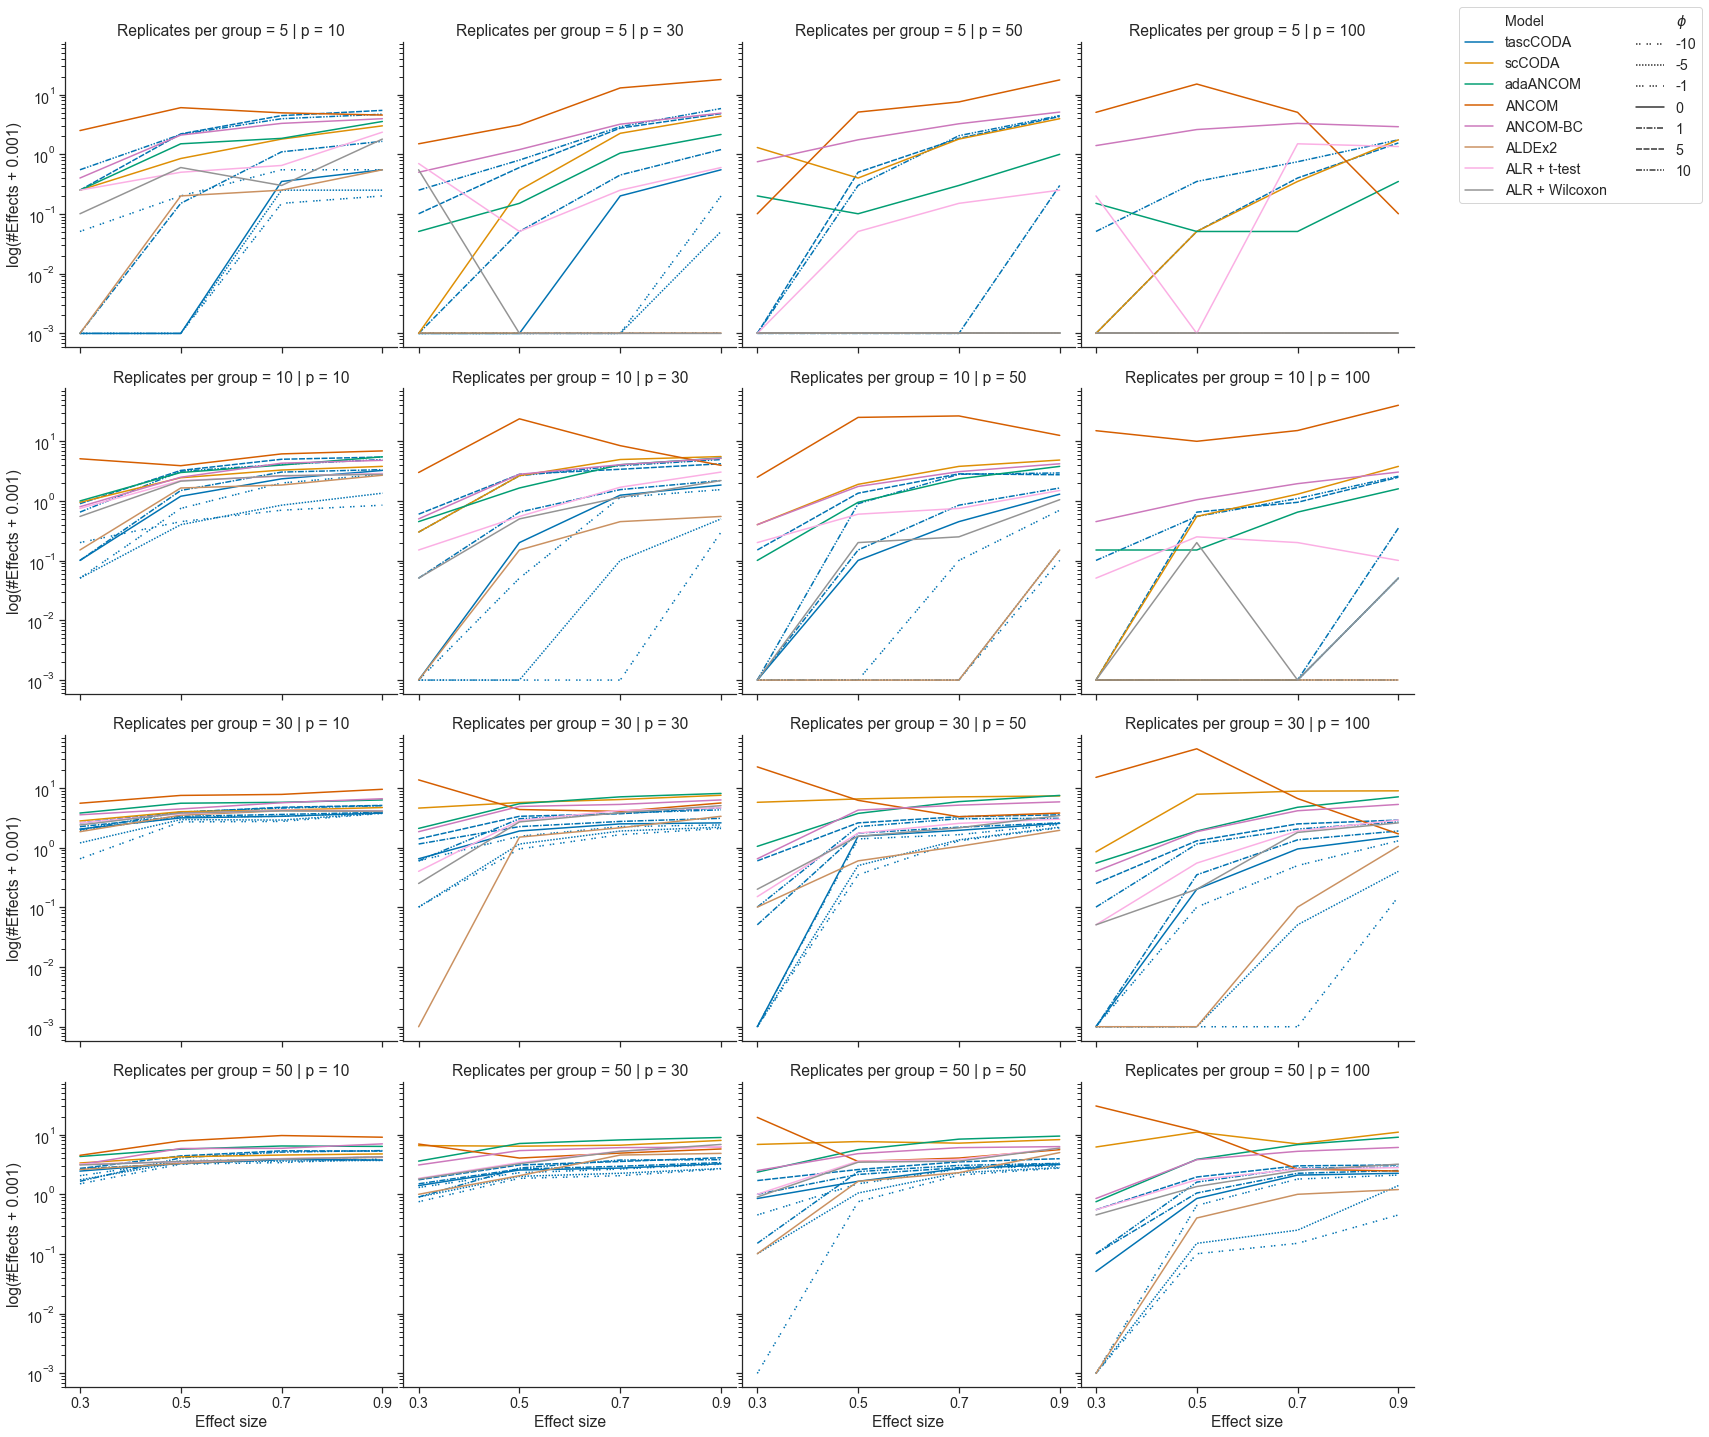

In [30]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_full, x="effect_size", y="num_effects",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                row="Replicates per group",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
g.set(yscale="log", xticks=[0.3, 0.5, 0.7, 0.9])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "log(#Effects + 0.001)").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_effects_16facets_v2.svg", bbox_inches="tight", format="svg")
plt.show()

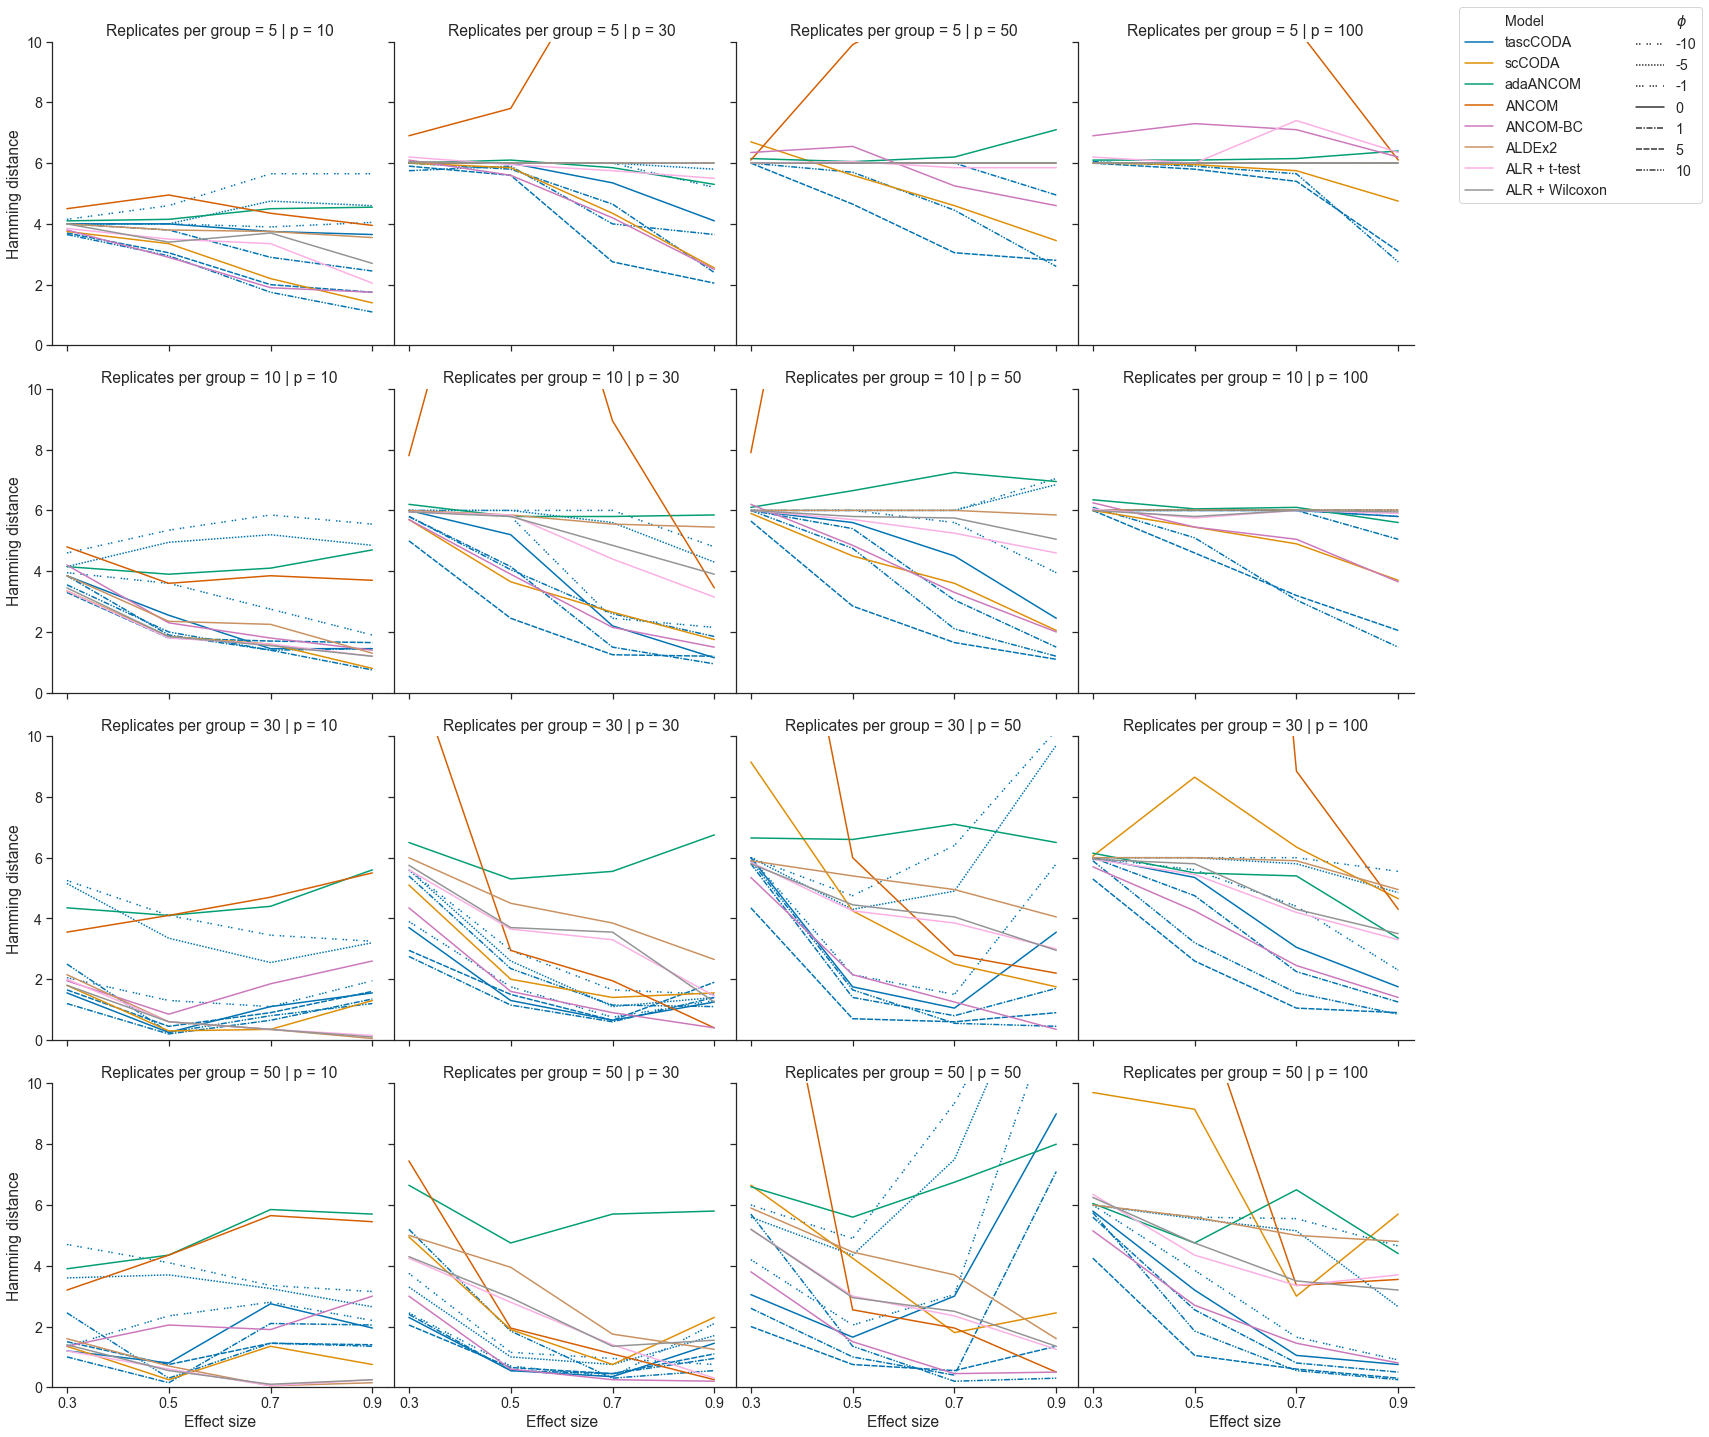

In [38]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_full, x="effect_size", y="hamming",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                row="Replicates per group",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
# g.set(yscale="log")
g.set(ylim=[0,10], xticks=[0.3, 0.5, 0.7, 0.9])

g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "Hamming distance").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_effects_16facets_v2.svg", bbox_inches="tight", format="svg")
plt.show()

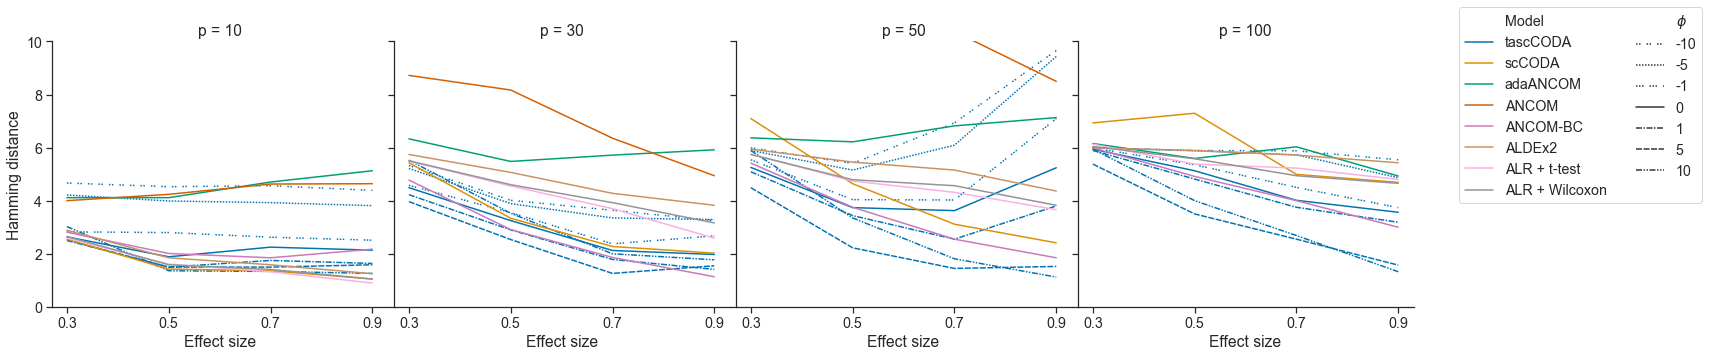

In [39]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_full, x="effect_size", y="hamming",
                hue="color",
                style="style_phi",
                dashes=ticks,
                palette="colorblind",
                col="p",
                # row="Replicates per group",
                kind="line",
                facet_kws = dict(legend_out=False),
                ci=None,
                #markers=True
            )
# g.set(yscale="log")
g.set(ylim=[0,10], xticks=[0.3, 0.5, 0.7, 0.9])

g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_, ncol=2, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "Hamming distance").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_effects_4facets_v2.svg", bbox_inches="tight", format="svg")
plt.show()

In [33]:
res_select = res_full[
(res_full["model"].isin(["tree_agg", "sccoda", "adaANCOM", "ANCOMBC", "ALDEx2"])) &
(res_full["phi"].isin([-5, 0, 5]))
]
ticks_select = [ticks[i] for i in[1, 3, 5]]
cols_select = [sns.color_palette("colorblind")[i] for i in [0, 1, 2, 4, 5]]
leg_labels_select=["Model", "tascCODA", "scCODA", "adaANCOM", "ANCOM-BC", "ALDEx2",
             r"$\phi$", "-5", "0", "5"]

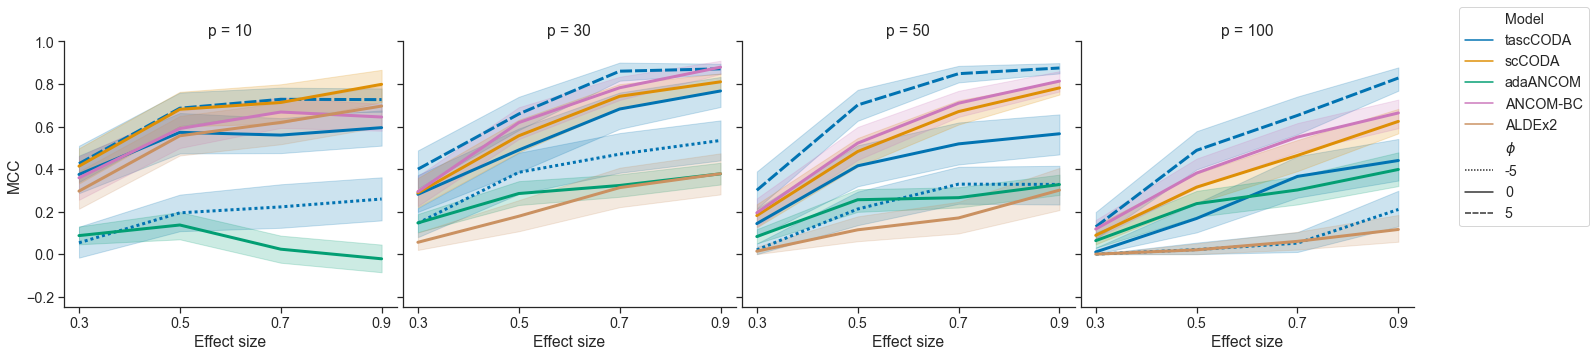

In [34]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_select, x="effect_size", y="mcc",
                hue="color",
                style="style_phi",
                dashes=ticks_select,
                palette=cols_select,
                col="p",
                # row="num_otus",
                kind="line",
                facet_kws = dict(legend_out=False),
                # ci=None,
                lw=3
                #markers=True
            )
g.set(ylim=[-0.25,1], xticks=[0.3, 0.5, 0.7, 0.9])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_select, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "MCC").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_mcc_4facets_select_v2.svg", bbox_inches="tight", format="svg")
plt.show()

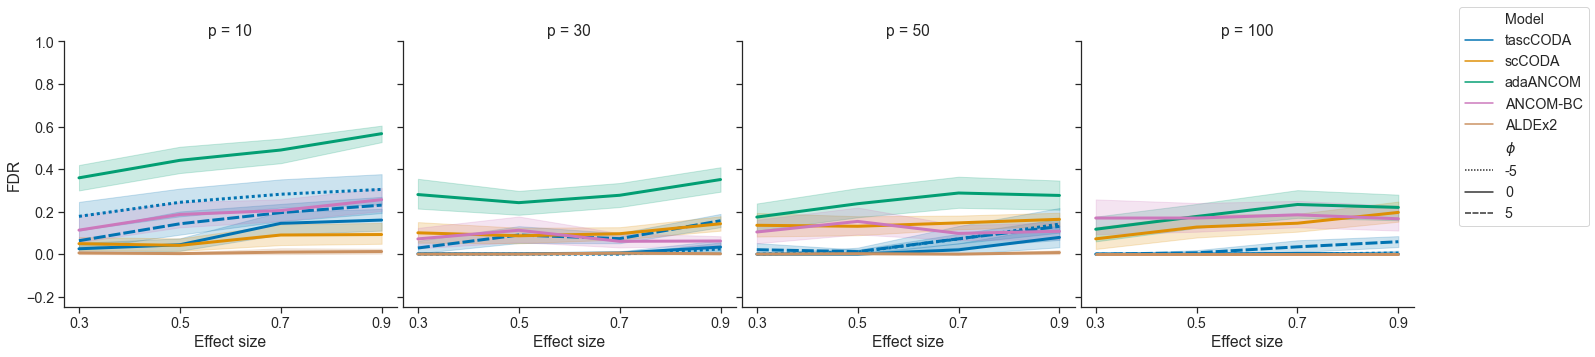

In [35]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_select, x="effect_size", y="fdr",
                hue="color",
                style="style_phi",
                dashes=ticks_select,
                palette=cols_select,
                col="p",
                # row="num_otus",
                kind="line",
                facet_kws = dict(legend_out=False),
                # ci=None,
                lw=3
                #markers=True
            )
g.set(ylim=[-0.25,1], xticks=[0.3, 0.5, 0.7, 0.9])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_select, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "FDR").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_fdr_4facets_select_v2.svg", bbox_inches="tight", format="svg")
plt.show()

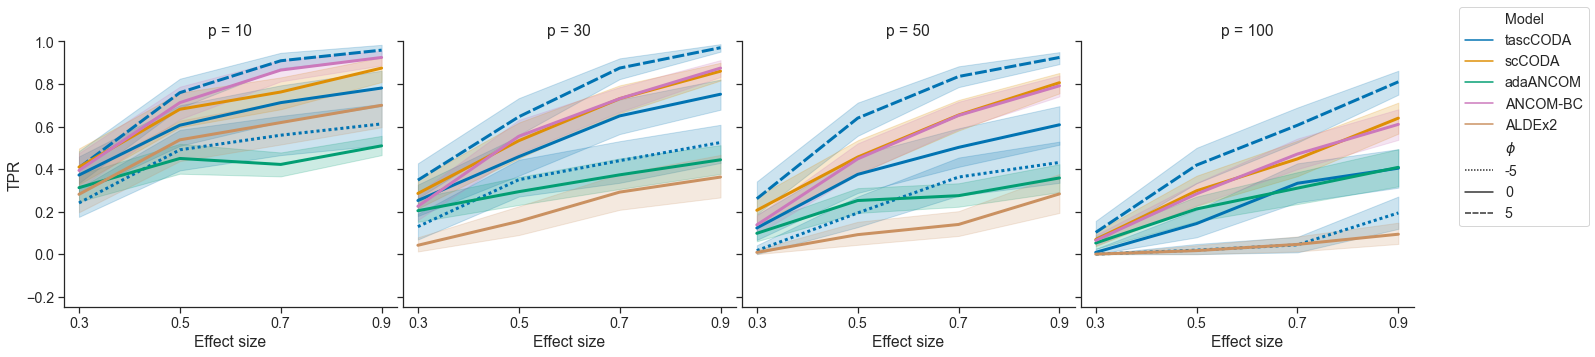

In [36]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_select, x="effect_size", y="tpr",
                hue="color",
                style="style_phi",
                dashes=ticks_select,
                palette=cols_select,
                col="p",
                # row="num_otus",
                kind="line",
                facet_kws = dict(legend_out=False),
                # ci=None,
                lw=3
                #markers=True
            )
g.set(ylim=[-0.25,1], xticks=[0.3, 0.5, 0.7, 0.9])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_select, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "TPR").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_tpr_4facets_select_v2.svg", bbox_inches="tight", format="svg")
plt.show()

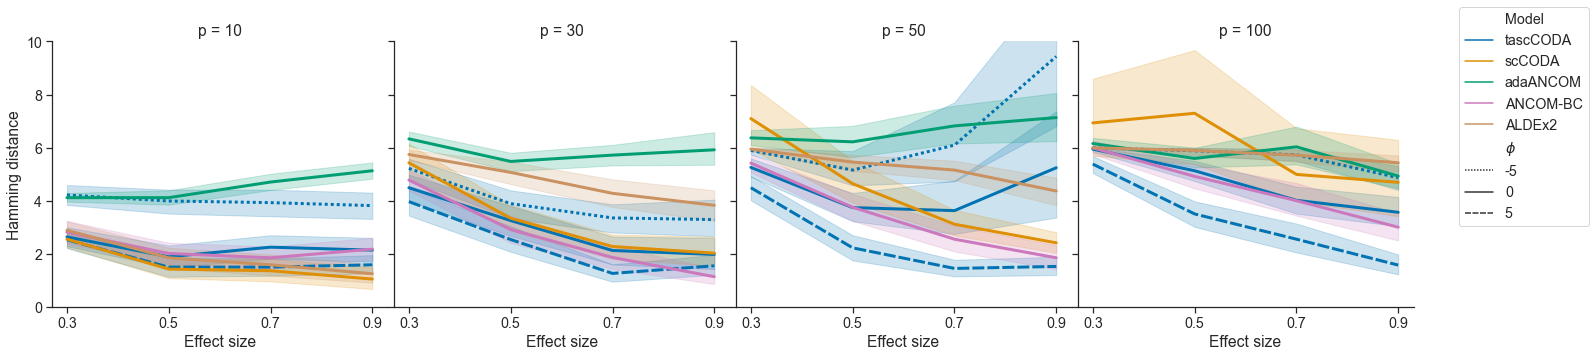

In [37]:
sns.set(style="ticks", font_scale=1.3)

g = sns.relplot(data=res_select, x="effect_size", y="hamming",
                hue="color",
                style="style_phi",
                dashes=ticks_select,
                palette=cols_select,
                col="p",
                # row="num_otus",
                kind="line",
                facet_kws = dict(legend_out=False),
                # ci=None,
                lw=3
                #markers=True
            )
g.set(ylim=[0, 10], xticks=[0.3, 0.5, 0.7, 0.9])
g._legend.remove()
h,l = g.axes.flat[0].get_legend_handles_labels()

g.fig.legend(h, leg_labels_select, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
(g.set_axis_labels("Effect size", "Hamming distance").tight_layout(w_pad=0))
plt.savefig(plot_path + "model_comp_hamming_4facets_select_v2.svg", bbox_inches="tight", format="svg")
plt.show()